In [157]:
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random as rand
import cv2
from IPython.display import clear_output

In [161]:
dataPath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\train.csv"
headPath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\head.txt"
predictionsPath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\data\predictions.csv"
faceCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_face.xml"
eyesCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_eye.xml"
leftEyeCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_leftEye.xml"
rightEyeCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_rightEye.xml"
mouthCascadePath = r"C:\Users\Aiden\OneDrive\Documents\Hackathon\haarcascades\haarcascade_mouth.xml"
upscalePath = "EDSR_x4.pb"

testPath = r"C:\Users\Aiden\Downloads\testFace.jpg"

#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
validLabels = {"0": "angry", "1": "disgust", "2": "fear", "3": "happy", "4": "sad", "5": "suprise", "6": "neutral",
                "angry": "0", "disgust": "1", "fear": "2", "happy": "3", "sad": "4", "surprise": "5", "neutral": "6"}

imgW = 48
imgH = 48



def apply_coverEyes_filter(pixelData):
    multichannel = np.stack((pixelData,)*3, axis=-1)
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(upscalePath)
    sr.setModel("edsr",4)
    upsampled = sr.upsample(multichannel)
    eyeSnip = upsampled[20:120,:,0].astype("uint8")

    eyesCascade = cv2.CascadeClassifier(eyesCascadePath)
    eyes = eyesCascade.detectMultiScale(eyeSnip, scaleFactor = 1.2, minNeighbors = 5)
    
    points = []
    for (x,y,width,height) in eyes:
        sx = x//4
        sy = int(y+20)//4
        sw = width//4
        sh = height//4
#         cv2.rectangle(pixelData, (sx,sy), (sx+sw,sy+sh), (255), 1)
        points.append((sx + sw//2, 47-(sy + sh//2)))
    
    if(len(points) == 0 or len(points) > 2):
        cv2.line(pixelData, (0, 15), (47, 15), (0), 10)
    elif(len(points) == 1):
        cv2.line(pixelData, (0, points[0][1]), (47, points[0][1]), (0), 10)
    else:
        m = (points[0][1]-points[1][1]) / (points[0][0] - points[1][0])
        y1 = int(m*(-points[0][0]) + points[0][1])
        y2 = int(m*(47-points[0][0]) + points[0][1])
        cv2.line(pixelData, (0, 47-y1), (47, 47-y2), (0), 10)       
        
        
def apply_coverMouth_filter(pixelData):
    multichannel = np.stack((pixelData,)*3, axis=-1)
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(upscalePath)
    sr.setModel("edsr",4)
    upsampled = sr.upsample(multichannel)
    mouthSnip = upsampled[80:180,:,0].astype("uint8")

    mouthCascade = cv2.CascadeClassifier(mouthCascadePath)
    mouths = mouthCascade.detectMultiScale(mouthSnip, scaleFactor = 1.15, minNeighbors = 4)
    
    if(len(mouths) > 0):
        (x,y,width,height) = mouths[-1]
        sx = x//4
        sy = int(y+80)//4
        sw = width//4
        sh = height//4
        cv2.line(pixelData, (0, sy+sh//2), (47, sy+sh//2), (0), sh)
    else:
        cv2.line(pixelData, (0, 35), (47, 35), (0), 10)

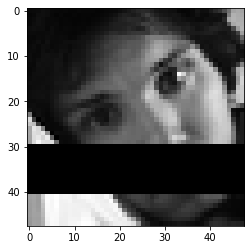

Prediction: exit
Saving at face 235


In [162]:
#'none', 'upside_down' 'cover_eyes', 'cover_mouth'
FILTER = 'cover_mouth'

#Read head file to know which face to start with
with open(headPath, 'r+') as h:
    
    headIndex = int(h.readlines()[0])
    startMsg = "Starting" if (headIndex==1) else "Resuming"
    print("{} at face {}".format(startMsg, headIndex))

    #Main prediction loop
    with open(dataPath, 'r') as f:
        with open(predictionsPath, 'a') as out:
            data = f.readlines()

            loop = True
            while(loop):
                faceData = data[headIndex].strip("\n").split(',')
                label = faceData[0]
                pixels = faceData[1][1:-1].split(" ")
                pixelData = np.asarray(pixels).reshape(imgH, imgW).astype("uint8")
                
                if(FILTER == 'cover_eyes'):
                    apply_coverEyes_filter(pixelData)
                elif(FILTER == 'upside_down'):
                    pixelData = np.rot90(pixelData, k=2)
                elif(FILTER == 'cover_mouth'):
                    apply_coverMouth_filter(pixelData)
                
                plt.imshow(pixelData, cmap='gray')
                plt.show()

                prediction = input("Prediction: ").lower()
                while(prediction not in validLabels and prediction != "exit"):
                    prediction = input("Not a valid label. Prediction: ").lower()
                loop = (prediction != "exit")
                if(not loop): continue

                predictionWrite = prediction if prediction.isdigit() else validLabels[prediction]
                if(loop): predictionWrite += ", "
                out.write(predictionWrite)
                
                headIndex += 1
                clear_output(wait=True)
            
            h.seek(0)
            h.write(str(headIndex))
            h.truncate()
            print("Saving at face {}".format(headIndex))
    

In [ ]:
## Reset Head
confirm = input("Are you sure you want to reset the head? Type 'Reset Head' to confirm\n\n")
if(confirm == "Reset Head"):
    with open(headPath, 'w') as f:
        f.write("1")
        print("Head reset")
else:
    print("Reset canceled")
    

In [45]:
#Reset Predictions
confirm = input("Are you sure you want to reset predictions? Type 'Reset Predictions' to confirm\n\n")
if(confirm == "Reset Predictions"):
    with open(predictionsPath, 'w') as f:
        print("Predictions reset")
else:
    print("Reset canceled")

Are you sure you want to reset predictions? Type 'Reset Predictions' to confirm

Reset Predictions
Predictions reset


In [46]:
#Shuffle Training Set
confirm = input("Are you sure you want to shuffle training data? Type 'Shuffle Training Data' to confirm\n\n")
if(confirm == "Shuffle Training Data"):
    with open(dataPath, 'r+') as f:
        data = f.readlines()
        rand.shuffle(data)
        f.truncate(0)
        [f.write(line) for line in data]
        print("Training data shuffled")
else:
    print("Shuffle canceled")

Are you sure you want to shuffle training data? Type 'Shuffle Training Data' to confirm

Shuffle Training Data
Training data shuffled
